# Diffusion Opinion

In [1]:
import os
import json
from tqdm import tqdm

import numpy as np
import random

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns


from weighted_opinion_diffusion import WeightedOpinionDiffusion
from opinion_diffusion_simulator import OpinionDiffusionSimulator
%load_ext autoreload
%autoreload 2

In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

In [3]:
# Carica il network completo
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

## Algorithmic Bias Model (NDlib)

Diffusione opinioni senza tenere conto dell'inizializzazione delle opinioni, della direzione e del peso degli archi.

In [4]:
# Gli algoritmi sopra cambiano il valore di 'opinion', bisogna ricaricare il network
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

real_graph = full_graph_backbone.to_undirected()

In [5]:
import itertools

# Stampa solo i primi 5 nodi con i loro attributi
for node, data in itertools.islice(real_graph.nodes(data=True), 5):
    print(f"Nodo {node}: {data}")

print('\n')
# Stampa solo i primi 5 archi con i loro attributi
for edge in itertools.islice(real_graph.edges(data=True), 5):
    print(edge)

Nodo Instr-FTO: {'opinion': 1.0, 'label': 'Instr-FTO'}
Nodo AutomaticDrop6236: {'opinion': 1.0, 'label': 'AutomaticDrop6236'}
Nodo Sufficient-Cat-5399: {'opinion': 1.0, 'label': 'Sufficient-Cat-5399'}
Nodo onearmedmonkey: {'opinion': 1.0, 'label': 'onearmedmonkey'}
Nodo Captainmanic: {'opinion': 1.0, 'label': 'Captainmanic'}


('Instr-FTO', 'AutomaticDrop6236', {'subreddit': 'trump', 'id': '0', 'weight': 2.0})
('Instr-FTO', 'Sufficient-Cat-5399', {'subreddit': 'trump', 'id': '15', 'weight': 3.0})
('Instr-FTO', 'onearmedmonkey', {'subreddit': 'trump', 'id': '2', 'weight': 2.0})
('Instr-FTO', 'Captainmanic', {'subreddit': 'trump', 'id': '3', 'weight': 2.0})
('Instr-FTO', 'Silent_Spell_3415', {'subreddit': 'trump', 'id': '61', 'weight': 2.0})


In [6]:
# Creiamo una mappatura da vecchi nomi a numeri
mapping = {node: i for i, node in enumerate(real_graph.nodes())}

# Rinominiamo i nodi
real_graph = nx.relabel_nodes(real_graph, mapping)

In [7]:
# Stampa solo i primi 5 nodi con i loro attributi
for node, data in itertools.islice(real_graph.nodes(data=True), 5):
    print(f"Nodo {node}: {data}")

print('\n')
# Stampa solo i primi 5 archi con i loro attributi
for edge in itertools.islice(real_graph.edges(data=True), 5):
    print(edge)

Nodo 0: {'opinion': 1.0, 'label': 'Instr-FTO'}
Nodo 1: {'opinion': 1.0, 'label': 'AutomaticDrop6236'}
Nodo 2: {'opinion': 1.0, 'label': 'Sufficient-Cat-5399'}
Nodo 3: {'opinion': 1.0, 'label': 'onearmedmonkey'}
Nodo 4: {'opinion': 1.0, 'label': 'Captainmanic'}


(0, 1, {'subreddit': 'trump', 'id': '0', 'weight': 2.0})
(0, 2, {'subreddit': 'trump', 'id': '15', 'weight': 3.0})
(0, 3, {'subreddit': 'trump', 'id': '2', 'weight': 2.0})
(0, 4, {'subreddit': 'trump', 'id': '3', 'weight': 2.0})
(0, 5, {'subreddit': 'trump', 'id': '61', 'weight': 2.0})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


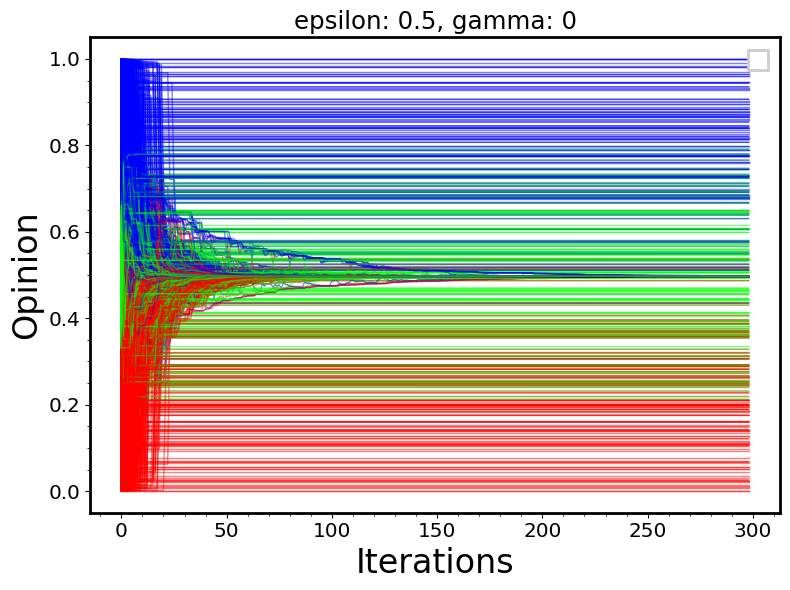

In [10]:
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op

model = op.AlgorithmicBiasModel(real_graph)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.5)
config.add_model_parameter("gamma", 0)  

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(300)

from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
viz = OpinionEvolution(model, iterations)

viz.plot()

## Diffusione con media pesata [NON UTILIZZATO] 

Il peso corrisponde all'attributo weight dell'arco entrante moltiplicato per la compatibility (1 - differenza di opinioni)

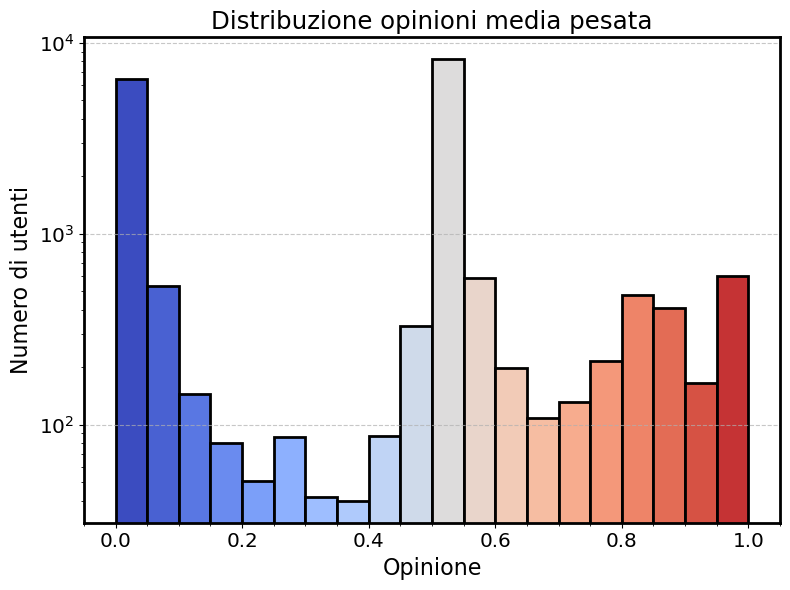

In [20]:
from weighted_opinion_diffusion_mean import WeightedOpinionDiffusionMean

iter = 200
random_opinion = False 
title = "Distribuzione opinioni media pesata"

# Carica il network completo
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

if random_opinion:
    # Sovrascrive attributo opinion con una variabile random in [0,1]
    for node in full_graph_backbone.nodes():
        full_graph_backbone.nodes[node]['opinion'] = random.uniform(0, 1)
    title = title + " (random init)"
    
# Inizializza il modello
model = WeightedOpinionDiffusionMean(full_graph_backbone, beta=0.5)

# Esegui iterazioni
proTrump = []
proBiden = []
neutral = []
for t in range(iter):
    new_opinions = model.iteration()
    opinions_array = np.asarray(list(new_opinions.values()))
    proTrump.append(opinions_array[opinions_array >= 0.6].size)
    proBiden.append(opinions_array[opinions_array <= 0.4].size)
    neutral.append(opinions_array[np.logical_and(opinions_array > 0.4, opinions_array < 0.6)].size)
    #print(f"Iterazione {t+1}")#

plot_opinion_distribution(new_opinions, title=title,  save=True)

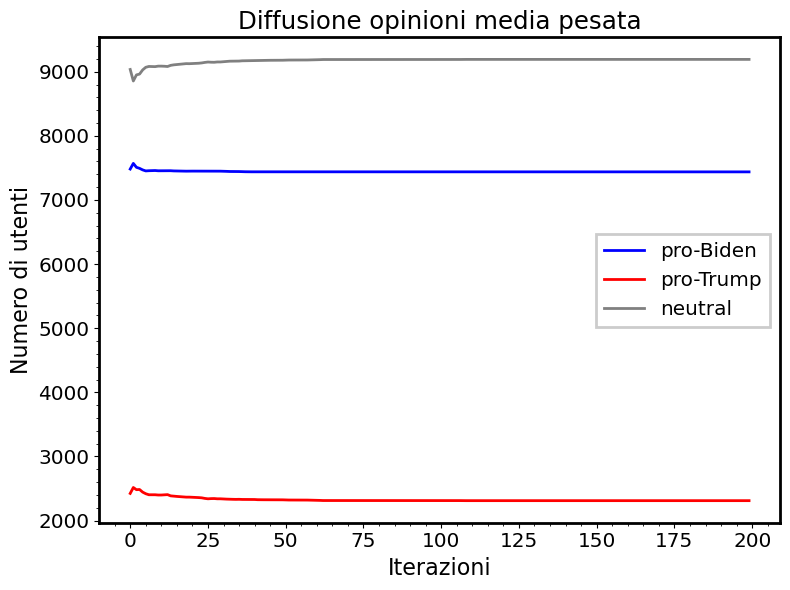

In [21]:
title = "Diffusione opinioni media pesata" 
if random_opinion: title = title + " (random init)"
plt.plot(range(iter), proBiden, color='b', label='pro-Biden')
plt.plot(range(iter), proTrump, color='r', label='pro-Trump')
plt.plot(range(iter), neutral, color='grey', label='neutral')
plt.xlabel("Iterazioni")
plt.ylabel("Numero di utenti")
plt.title(title)
plt.legend()
plt.savefig(os.path.join("plots", title))
plt.show()

## Distribuzione opinone con un solo nodo

Invece di fare la media pesata viene estratto con una certa probabilità un nodo casuale tra i vicini entranti (ulteriori informazioni sul modello sono presenti nel file weighted_opinion_diffusion.py). 
Plots e iterazioni sono gestite dalla classe OpinionDiffusionSimulator nel file opinion_diffusion_simulator.py

In [49]:
simulator = OpinionDiffusionSimulator(full_graph_backbone, 
                                      iterations=50, 
                                      epsilon=0.3, 
                                      bias=5, 
                                      reduced_weight=True,
                                      random_opinion=False)
simulator.run_simulation()

100%|███████████████████████████████████████████| 50/50 [00:14<00:00,  3.47it/s]


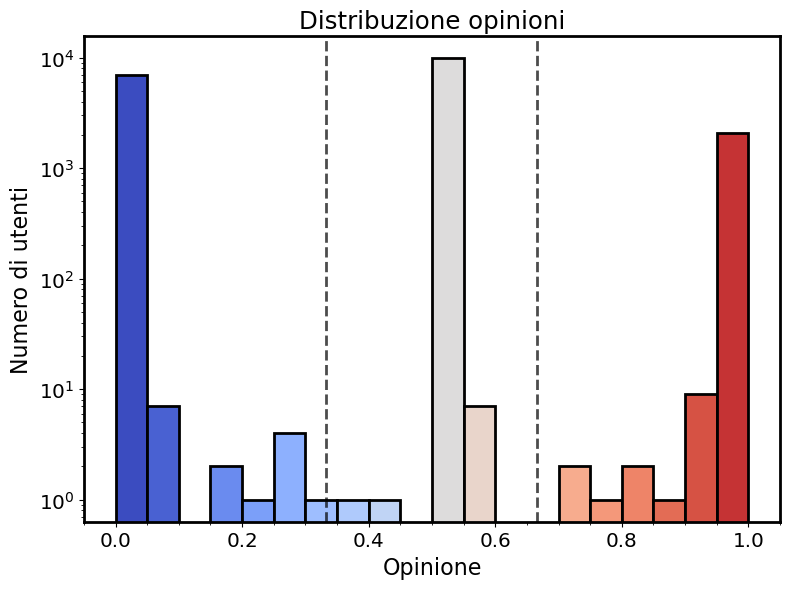

In [50]:
simulator.plot_opinion_distribution(save=False) # Istogramma delle opinioni finali (ultima iterazione)

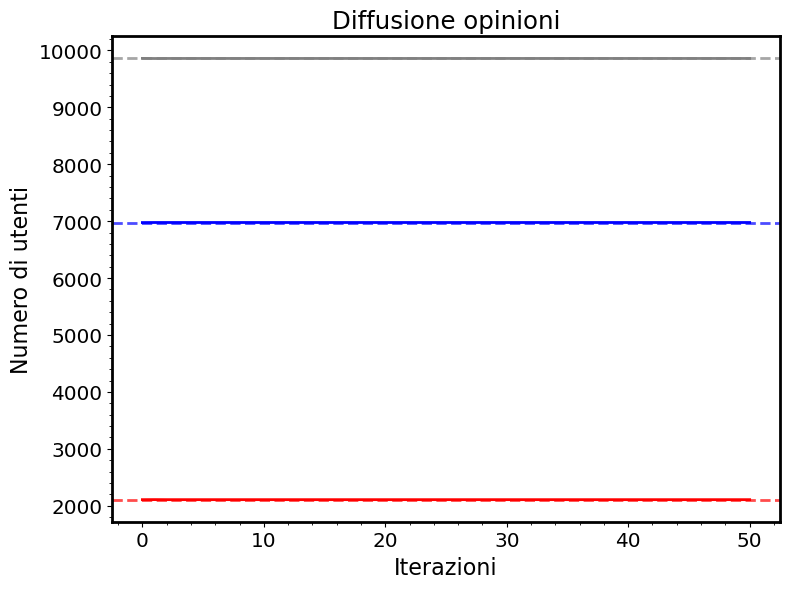

In [51]:
# Plot opinioni discretizzate in tre categorie: pro_Trump, pro-Biden e Neutral
# La discretizzazione divide in tre parti uguali i valori delle opinioni, 
# la divisione si può vedere nelle line tratteggiate dell'istogramma precedente
# Le linee tratteggiate sono i valori di inizializzazione
simulator.plot_opinion_diffusion(save=False) 

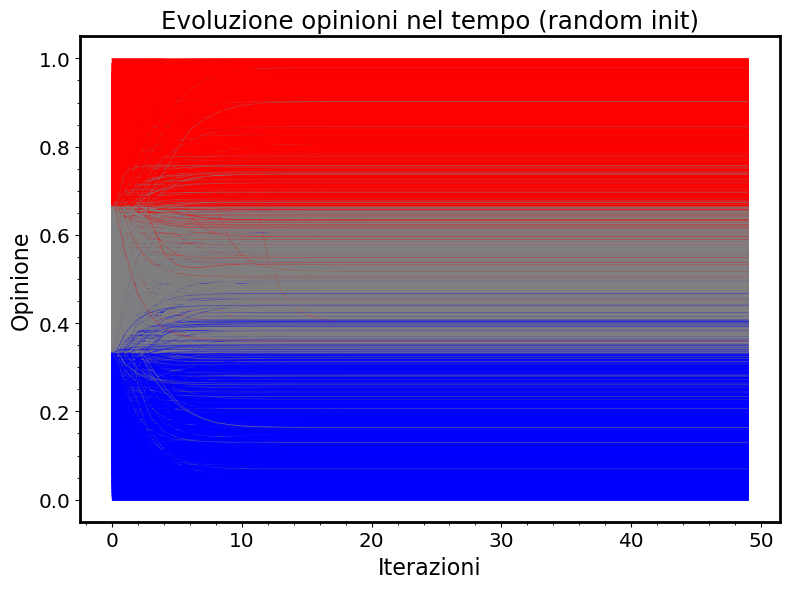

In [19]:
# Plot della variazione di opinione di ogni utente
# Il colore dipende dall'opinione iniziale
simulator.plot_opinion_evolution(save=False)

### Variazione parametri

In [61]:
random_opinion = False
epsilon_values = [0.3, 0.5, 1, 0.3, 0.3, 0.3]
bias_values = [0, 0, 0, 0.5, 1, 5]

simulator = []
for i, (epsilon, bias) in enumerate(zip(epsilon_values, bias_values)):
    
    simulator.append(OpinionDiffusionSimulator(full_graph_backbone, 
                                               iterations=50, 
                                               epsilon=epsilon, 
                                               bias=bias, 
                                               reduced_weight=True,
                                               random_opinion=random_opinion
                                              ))
    simulator[i].run_simulation()

100%|███████████████████████████████████████████| 50/50 [00:14<00:00,  3.35it/s]


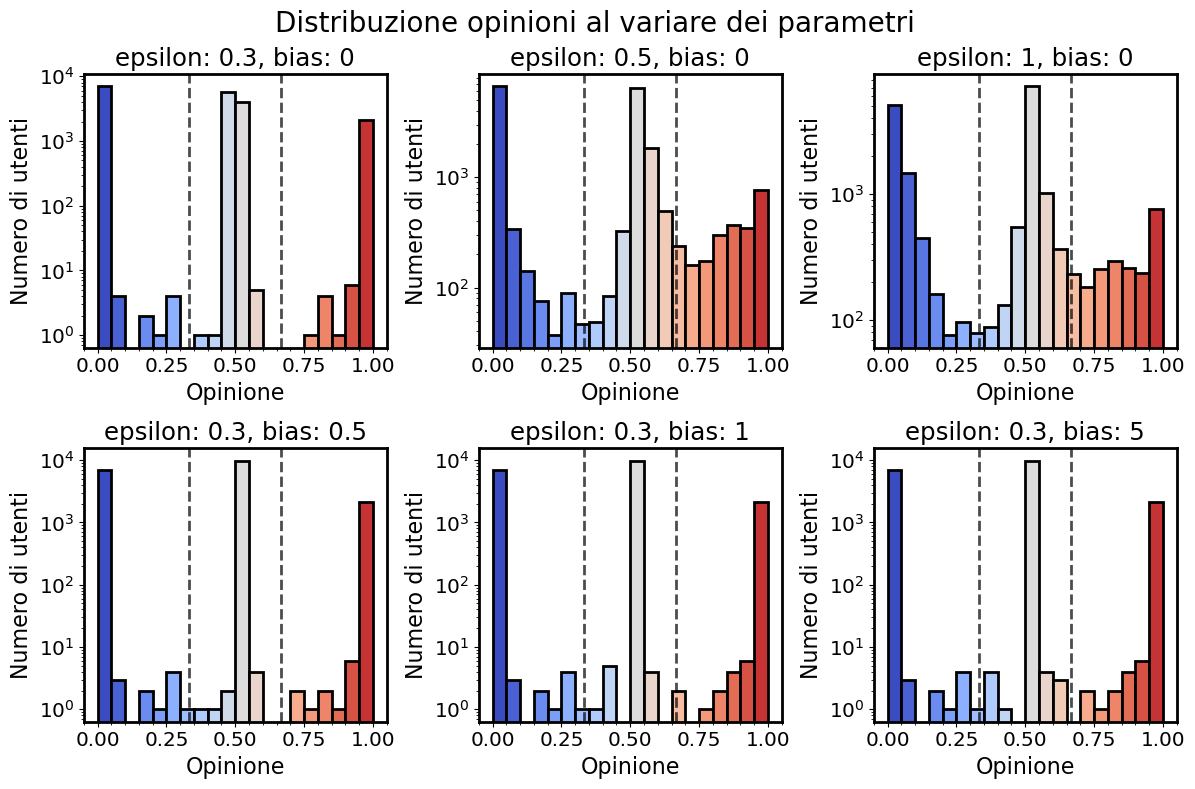

In [62]:
# Crea una figura con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()  # Converte la matrice 2x3 in un array per un facile accesso

for i, (epsilon, bias) in enumerate(zip(epsilon_values, bias_values)):
    ax = axes[i]
    simulator[i].plot_opinion_distribution(title=f'epsilon: {epsilon}, bias: {bias}', 
                                           ax=ax,
                                           save=False 
                                          )
    if random_opinion: ax.set_title(f'epsilon: {epsilon}, bias: {bias}')
    
# Aggiungere un titolo alla figura
title = "Distribuzione opinioni al variare dei parametri"
if random_opinion: title += " (random init)"
fig.suptitle(title, fontsize=20)

# Regolare gli spazi tra i grafici
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale

# Salva l'immagine in un file
plt.savefig(os.path.join("plots", title))
plt.show()

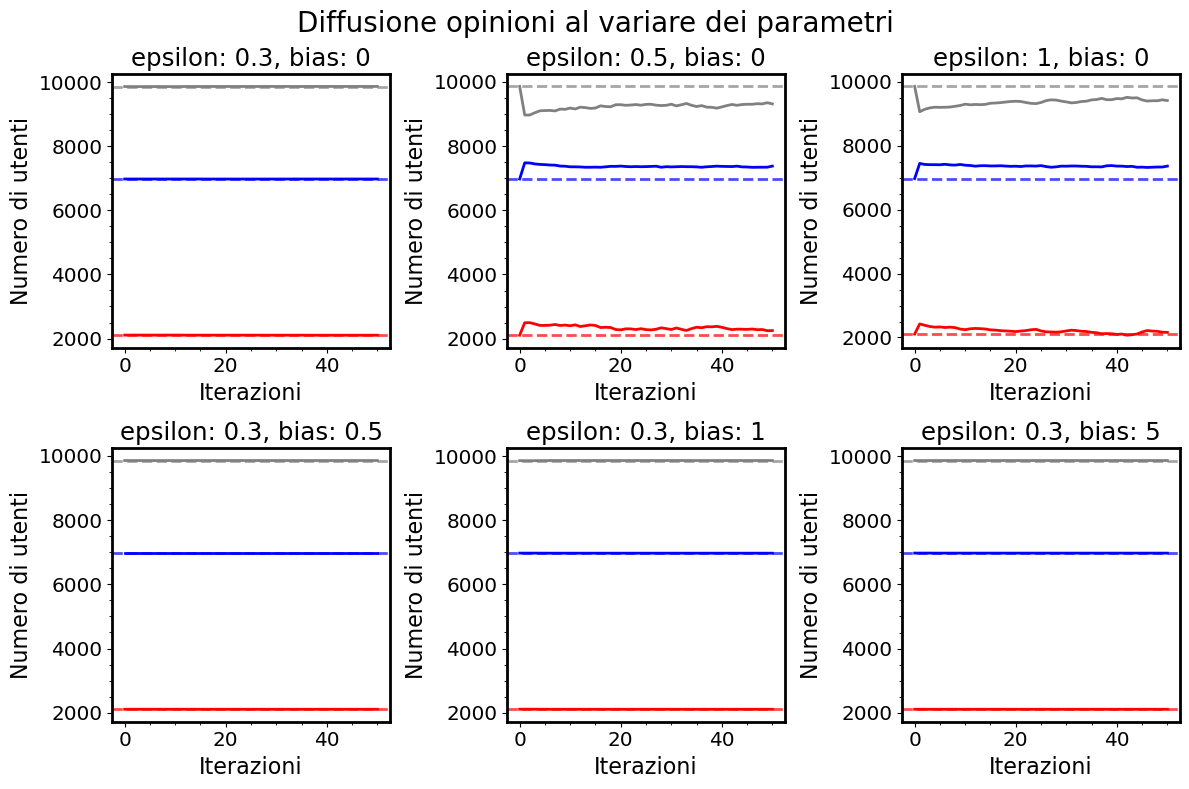

In [63]:
# Crea una figura con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()  # Converte la matrice 2x3 in un array per un facile accesso

for i, (epsilon, bias) in enumerate(zip(epsilon_values, bias_values)):
    ax = axes[i]
    simulator[i].plot_opinion_diffusion(title=f'epsilon: {epsilon}, bias: {bias}',
                                        ax=ax,
                                        save=False,
                                       )    
    if random_opinion: ax.set_title(f'epsilon: {epsilon}, bias: {bias}')

# Aggiungere un titolo alla figura
title = "Diffusione opinioni al variare dei parametri"
if random_opinion: title += " (random init)"
fig.suptitle(title, fontsize=20)

# Regolare gli spazi tra i grafici
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale

# Salva l'immagine in un file
plt.savefig(os.path.join("plots", title))
plt.show()

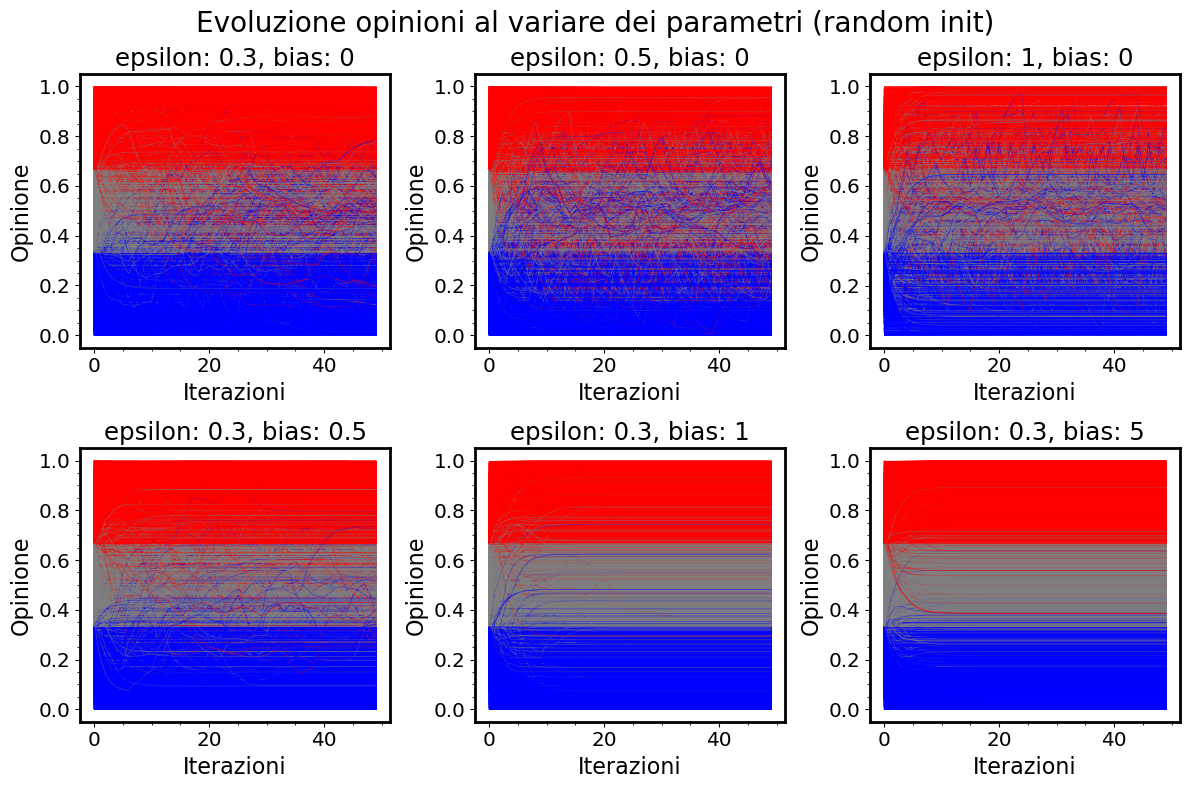

In [60]:
# Crea una figura con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()  # Converte la matrice 2x3 in un array per un facile accesso

for i, (epsilon, bias) in enumerate(zip(epsilon_values, bias_values)):
    ax = axes[i]
    simulator[i].plot_opinion_evolution(title=f'epsilon: {epsilon}, bias: {bias}',
                                        ax=ax,
                                        save=False,
                                       )    
    if random_opinion: ax.set_title(f'epsilon: {epsilon}, bias: {bias}')

# Aggiungere un titolo alla figura
title = "Evoluzione opinioni al variare dei parametri"
if random_opinion: title += " (random init)"
fig.suptitle(title, fontsize=20)

# Regolare gli spazi tra i grafici
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale

# Salva l'immagine in un file
plt.savefig(os.path.join("plots", title))
plt.show()

## Variazione snapshots

In [51]:
random_opinion = True

simulator = []
for i in range(6):
    week_graph = nx.read_gexf(os.path.join("..","data_collection","graph", f"network_week_{i+1}.gexf"))
    simulator.append(OpinionDiffusionSimulator(week_graph, 
                                               iterations=50, 
                                               epsilon=0.3, 
                                               bias=1.0, 
                                               reduced_weight=True,
                                               random_opinion=random_opinion
                                              ))
    simulator[i].run_simulation()

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 14.33it/s]


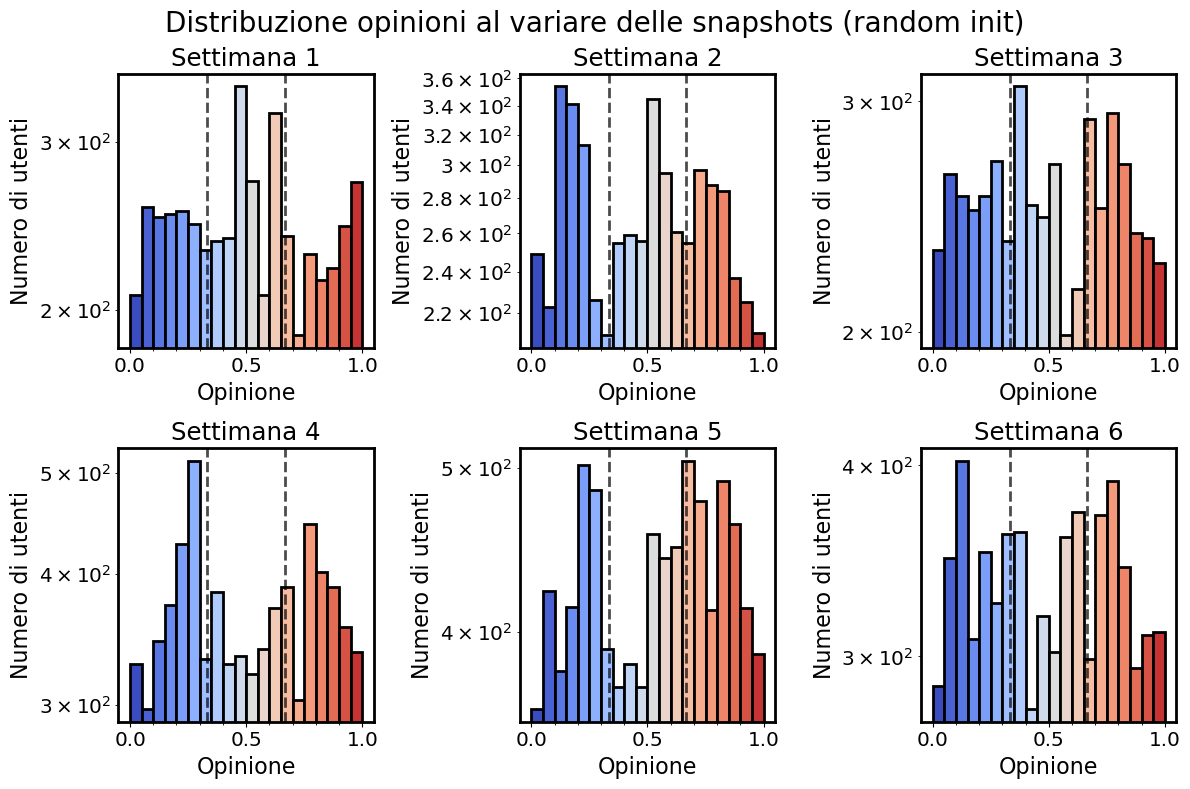

In [54]:
# Crea una figura con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()  # Converte la matrice 2x3 in un array per un facile accesso

for i in range(6):
    ax = axes[i]
    simulator[i].plot_opinion_distribution(title=f'Settimana {i}', 
                                           ax=ax,
                                           save=False 
                                          )
    if random_opinion: ax.set_title(f'Settimana {i+1}')
    
# Aggiungere un titolo alla figura
title = "Distribuzione opinioni al variare delle snapshots"
if random_opinion: title += " (random init)"
fig.suptitle(title, fontsize=20)

# Regolare gli spazi tra i grafici
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale

# Salva l'immagine in un file
plt.savefig(os.path.join("plots", title))
plt.show()

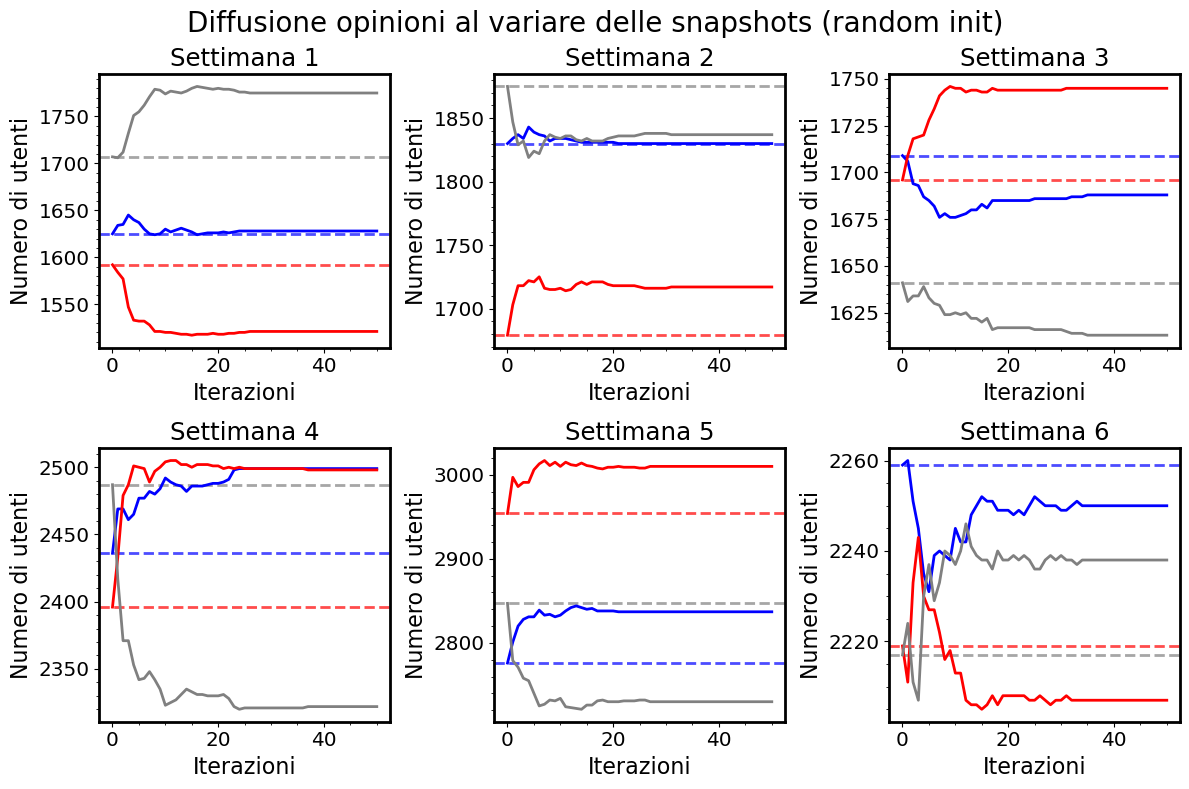

In [55]:
# Crea una figura con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()  # Converte la matrice 2x3 in un array per un facile accesso

for i in range(6):
    ax = axes[i]
    simulator[i].plot_opinion_diffusion(title=f'Settimana {i}',
                                        ax=ax,
                                        save=False,
                                       )    
    if random_opinion: ax.set_title(f'Settimana {i+1}')

# Aggiungere un titolo alla figura
title = "Diffusione opinioni al variare delle snapshots"
if random_opinion: title += " (random init)"
fig.suptitle(title, fontsize=20)

# Regolare gli spazi tra i grafici
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale

# Salva l'immagine in un file
plt.savefig(os.path.join("plots", title))
plt.show()

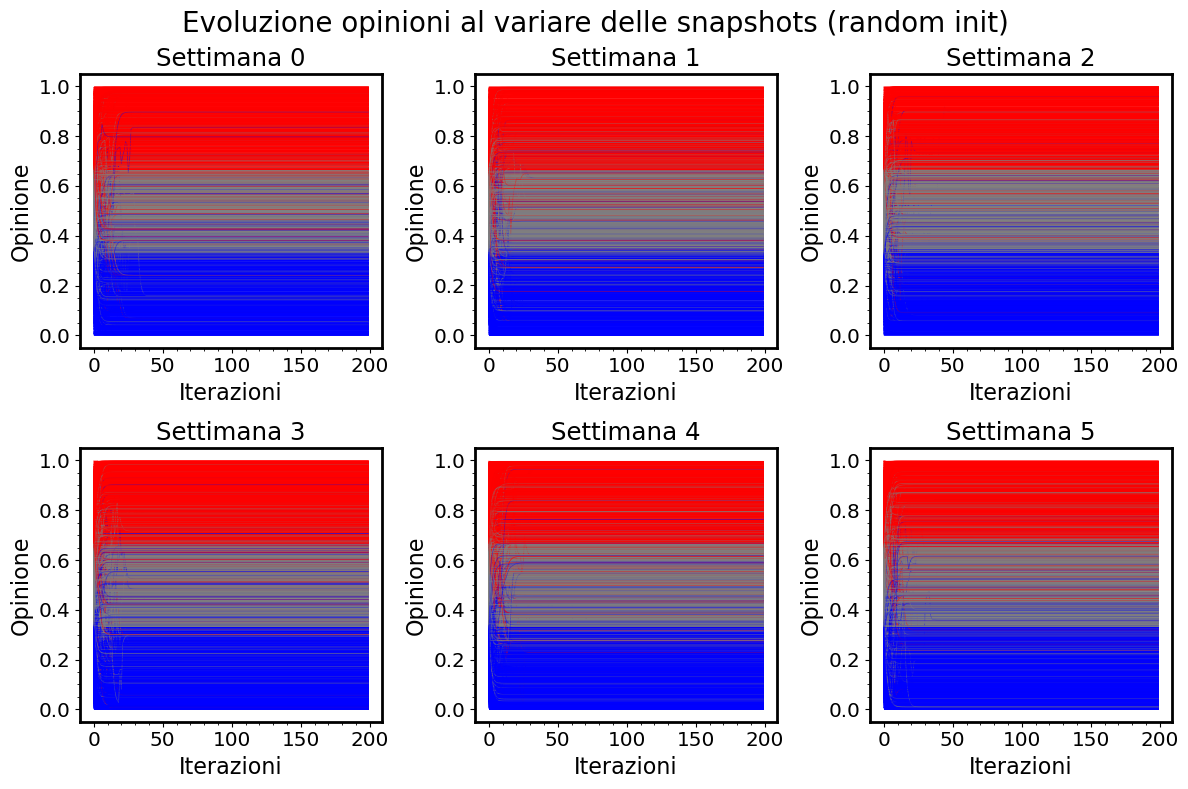

In [38]:
# Crea una figura con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()  # Converte la matrice 2x3 in un array per un facile accesso

for i in range(6):
    ax = axes[i]
    simulator[i].plot_opinion_evolution(title=f'Settimana {i}',
                                        ax=ax,
                                        save=False,
                                       )    
    if random_opinion: ax.set_title(f'Settimana {i+1}')

# Aggiungere un titolo alla figura
title = "Evoluzione opinioni al variare delle snapshots"
if random_opinion: title += " (random init)"
fig.suptitle(title, fontsize=20)

# Regolare gli spazi tra i grafici
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale

# Salva l'immagine in un file
plt.savefig(os.path.join("plots", title))
plt.show()